In [1]:
# Clone the repository with necessary files to create the MTCNN models
!git clone https://github.com/mauriciobarroso/mtcnn_esp32s3.git

Cloning into 'mtcnn_esp32s3'...
remote: Enumerating objects: 805, done.
remote: Counting objects: 100% (805/805), done.
remote: Compressing objects: 100% (576/576), done.
remote: Total 805 (delta 212), reused 801 (delta 212), pack-reused 0
Receiving objects: 100% (805/805), 19.16 MiB | 28.81 MiB/s, done.
Resolving deltas: 100% (212/212), done.


In [2]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import time
import sys
sys.path.insert(0, "mtcnn_esp32s3/")
import mtcnn
import utils

In [3]:
# Define the paths to save the models files
import os

# Create the main folder
MODELS_DIR = 'models/'

if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

# Define the paths for each model that will be generated
PNET_SCALE_1_TF = MODELS_DIR + 'pnet_scale_1'
PNET_SCALE_2_TF = MODELS_DIR + 'pnet_scale_2'
RNET_TF = MODELS_DIR + 'rnet'
ONET_TF = MODELS_DIR + 'onet'
PNET_SCALE_1_NO_QUANT_TFLITE = MODELS_DIR + 'pnet_scale_1_no_quant.tflite'
PNET_SCALE_2_NO_QUANT_TFLITE = MODELS_DIR + 'pnet_scale_2_no_quant.tflite'
RNET_NO_QUANT_TFLITE = MODELS_DIR + 'rnet_no_quant.tflite'
ONET_NO_QUANT_TFLITE = MODELS_DIR + 'onet_no_quant.tflite'
PNET_SCALE_1_QUANT_INT8_TFLITE = MODELS_DIR + 'pnet_scale_1_quant_int8.tflite'
PNET_SCALE_2_QUANT_INT8_TFLITE = MODELS_DIR + 'pnet_scale_2_quant_int8.tflite'
RNET_QUANT_INT8_TFLITE = MODELS_DIR + 'rnet_quant_int8.tflite'
ONET_QUANT_INT8_TFLITE = MODELS_DIR + 'onet_quant_int8.tflite'
PNET_SCALE_1_TFLITE_MICRO = MODELS_DIR + 'pnet_scale_1.cc'
PNET_SCALE_2_TFLITE_MICRO = MODELS_DIR + 'pnet_scale_2.cc'
RNET_TFLITE_MICRO = MODELS_DIR + 'rnet.cc'
ONET_TFLITE_MICRO = MODELS_DIR + 'onet.cc'

# Print the generated paths
print(PNET_SCALE_1_TF)
print(PNET_SCALE_2_TF)
print(RNET_TF)
print(ONET_TF)
print(PNET_SCALE_1_NO_QUANT_TFLITE)
print(PNET_SCALE_2_NO_QUANT_TFLITE)
print(RNET_NO_QUANT_TFLITE)
print(ONET_NO_QUANT_TFLITE)
print(PNET_SCALE_1_QUANT_INT8_TFLITE)
print(PNET_SCALE_2_QUANT_INT8_TFLITE)
print(RNET_QUANT_INT8_TFLITE)
print(ONET_QUANT_INT8_TFLITE)
print(PNET_SCALE_1_TFLITE_MICRO)
print(PNET_SCALE_2_TFLITE_MICRO)
print(RNET_TFLITE_MICRO)
print(ONET_TFLITE_MICRO)

models/pnet_scale_1
models/pnet_scale_2
models/rnet
models/onet
models/pnet_scale_1_no_quant.tflite
models/pnet_scale_2_no_quant.tflite
models/rnet_no_quant.tflite
models/onet_no_quant.tflite
models/pnet_scale_1_quant_int8.tflite
models/pnet_scale_2_quant_int8.tflite
models/rnet_quant_int8.tflite
models/onet_quant_int8.tflite
models/pnet_scale_1.cc
models/pnet_scale_2.cc
models/rnet.cc
models/onet.cc


In [4]:
# Define the scales for the P-Net model
scales = [0.1, 0.166666666666667]

# Define the MTCNN thresholds
mtcnn_thresholds = [0.7, 0.7, 0.75]

# Define NMS thresholds
nms_thresholds = [0.7, 0.7, 0.7]

# Define the input image shape
w, h, ch = 176, 144, 3

# Creation of the models

In [5]:
# P-Net

# Create lists to append all the P-Net models generated for all scales
pnets = [] # P-Nets TF
pnets_no_quant = [] # P-Nets TF Lite no quantized
pnets_quant_int8 = [] # P-Nets TF Lite quantized int8

# Create the models for all scale
for scale in scales:
  print("Creating model for scale:", scale)

  # Get the scaled width and height
  ws, hs = int(w * scale), int(h * scale)

  # Create the TF model for the current scale
  pnet_scale = mtcnn.create_pnet(ws, hs, "mtcnn_esp32s3/mtcnn_models/12net.h5")

  # Convert the TF model to the TF Lite no quantized format
  converter = tf.lite.TFLiteConverter.from_keras_model(pnet_scale)
  pnet_scale_no_quant = converter.convert()

  # Function to generate a representative dataset to convert to TF Lite quantized
  def representative_dataset():
    for i, image_file in enumerate(os.listdir("mtcnn_esp32s3/representative_dataset/")):
      if i < 70:
        image_input = cv2.imread("mtcnn_esp32s3/representative_dataset/" + image_file)
        image_input = np.expand_dims(utils.preprocess_image(image_input, hs, ws, np.float32), axis=0)
        yield [image_input.astype(np.float32)]

  # Convert the TF model to the TF Lite quantized format 
  converter.optimizations = [tf.lite.Optimize.DEFAULT] # Set the optimization flag
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # Enforce integer only quantization
  converter.inference_input_type = tf.int8 # Define the quantization data type
  converter.representative_dataset = representative_dataset # Provide a representative dataset to ensure we quantize correctly.
  pnet_scale_quant_int8 = converter.convert()

  # Append the scaled TF, TF lite no quantized and TF Lite quantized models to its corresponded list 
  pnets.append(pnet_scale)
  pnets_no_quant.append(pnet_scale_no_quant)
  pnets_quant_int8.append(pnet_scale_quant_int8)

  print("Done!")

# Save the models to disk
pnets[0].save(PNET_SCALE_1_TF)
pnets[1].save(PNET_SCALE_2_TF)
open(PNET_SCALE_1_NO_QUANT_TFLITE, "wb").write(pnets_no_quant[0])
open(PNET_SCALE_2_NO_QUANT_TFLITE, "wb").write(pnets_no_quant[1])
open(PNET_SCALE_1_QUANT_INT8_TFLITE, "wb").write(pnets_quant_int8[0])
open(PNET_SCALE_2_QUANT_INT8_TFLITE, "wb").write(pnets_quant_int8[1])


Creating model for scale: 0.1


/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Done!
Creating model for scale: 0.166666666666667


/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Done!


13984

In [6]:
# R-Net

# Create model
rnet = mtcnn.create_rnet("mtcnn_esp32s3/mtcnn_models/24net.h5")

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(rnet)
rnet_no_quant = converter.convert()

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i, image_file in enumerate(os.listdir("mtcnn_esp32s3/representative_dataset/")):
    if i < 70:
      image_input = cv2.imread("mtcnn_esp32s3/representative_dataset/" + image_file)
      image_input = np.expand_dims(utils.preprocess_image(image_input, 24, 24, np.float32), axis=0)
      yield [image_input.astype(np.float32)]

# Set the optimization flag
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
rnet_quant_int8 = converter.convert()

# Save models to disk
rnet.save(RNET_TF)
open(RNET_NO_QUANT_TFLITE, "wb").write(rnet_no_quant)
open(RNET_QUANT_INT8_TFLITE, "wb").write(rnet_quant_int8)

/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


111632

In [7]:
# O-Net

# Create model
onet = mtcnn.create_onet("mtcnn_esp32s3/mtcnn_models/48net.h5")

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(onet)
onet_no_quant = converter.convert()

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i, image_file in enumerate(os.listdir("mtcnn_esp32s3/representative_dataset/")):
    if i < 70:
      image_input = cv2.imread("mtcnn_esp32s3/representative_dataset/" + image_file)
      image_input = np.expand_dims(utils.preprocess_image(image_input, 48, 48, np.float32), axis=0)
      yield [image_input.astype(np.float32)]

# Set the optimization flag
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
onet_quant_int8 = converter.convert()

# Save models to disk
onet.save(ONET_TF)
open(ONET_NO_QUANT_TFLITE, "wb").write(onet_no_quant)
open(ONET_QUANT_INT8_TFLITE, "wb").write(onet_quant_int8)

/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


403544

# MTCNN run functions

In [8]:
# P-Net

def run_pnet(image, pnets_models, tflite=False, quantized=False):
  bounding_boxes = []
  
  # Run the P-Net model for all scales
  for i, scale in enumerate(scales):
    # Get the scaled widht and height
    h_scale, w_scale = int(h * scale), int(w * scale)

    # Resize the image for curret scale
    input_image = cv2.resize(image, (h_scale, w_scale))

    # Reshape the image to match the expected shape of the model
    input_image = input_image.reshape(1, * input_image.shape)

    # Change the image type according on whether the quantization is enabled
    if quantized == True:
      input_image = np.floor(input_image * 127)
      input_image = input_image.astype(np.int8)
    else:
      input_image = input_image.astype(np.float32)

    # Run the inference for the TF Lite models
    if tflite == True:
      # Configure TF Lite interpreter
      pnet_tflite_interpreter = tf.lite.Interpreter(model_content=pnets_models[i])
      pnet_tflite_interpreter.allocate_tensors()
      input_details = pnet_tflite_interpreter.get_input_details()
      output_details = pnet_tflite_interpreter.get_output_details()

      # Set TF Lite interpretet input tensor
      pnet_tflite_interpreter.set_tensor(input_details[0]["index"], input_image)
      pnet_tflite_interpreter.invoke()
      
      # Get inference results
      probs = pnet_tflite_interpreter.get_tensor(output_details[0]["index"])
      offsets = pnet_tflite_interpreter.get_tensor(output_details[1]["index"])
    # Run the inference for the TF model
    else:
      # Get inference results
      probs, offsets = pnets_models[i].predict(input_image)

    # Reduce the shape of probs
    probs = probs[0, :, :, 1]
    
    # Get the boxes with a probability greater than the threshold for P-Net
    inds = np.where(probs > mtcnn_thresholds[0])

    if inds[0].size == 0:
      boxes = None
    else:
      tx1, ty1, tx2, ty2 = [offsets[0, inds[0], inds[1], i] for i in range(4)]
      offsets = np.array([tx1, ty1, tx2, ty2])
      score = probs[inds[0], inds[1]]
      bounding_box = np.vstack([
        np.round((2 * inds[1] + 1.0) / scale),
        np.round((2 * inds[0] + 1.0) / scale),
        np.round((2 * inds[1] + 1.0 + 12) / scale),
        np.round((2 * inds[0] + 1.0 + 12) / scale),
        score, offsets
      ])

      boxes = bounding_box.T
    
    # Append all candidate windows
    bounding_boxes.append(boxes)
    print(bounding_boxes)

  # Collect boxes (and offsets, and scores) from different scales
  bounding_boxes = [i for i in bounding_boxes if i is not None]
  bounding_boxes = np.vstack(bounding_boxes)
  keep = utils.nms(bounding_boxes[:, 0:5], nms_thresholds[0])
  bounding_boxes = bounding_boxes[keep]


  # Use offsets predicted by P-Net to transform bounding boxes
  bounding_boxes = utils.calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
  bounding_boxes = utils.convert_to_square(bounding_boxes)
  bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
  
  return bounding_boxes

In [9]:
# R-Net

def run_rnet(candidate_windows, rnet_model, tflite=False, quantized=False):
  # Define the R-Net windows size
  size = 24

  # Get the corrected boxes
  bounding_boxes = candidate_windows
  num_boxes = len(bounding_boxes)
  [dy, edy, dx, edx, y, ey, x, ex, width, height] = utils.correct_bboxes(bounding_boxes, w, h)

  # Crop from the original image the boxes to feed R-Net
  img_boxes = np.zeros((num_boxes, size, size, ch))
  for i in range(num_boxes):
      img_box = np.zeros((height[i], width[i], ch))
      img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] = image_test[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]

      # Resize and change
      img_box = cv2.resize(img_box, (size, size))
      img_boxes[i, :, :, :] = img_box

  # Change the image type according on whether the quantization is enabled
  if quantized == True:
    # Convert image from float32 to int8
    img_boxes = np.floor(img_boxes * 127)
    img_boxes = img_boxes.astype(np.int8)
  else:
    img_boxes = img_boxes.astype(np.float32)

  # Run the inference for the TF Lite models
  if tflite == True:
    # Configure TF Lite interpreter
    tflite_interpreter = tf.lite.Interpreter(model_content=rnet_model)
    input_details = tflite_interpreter.get_input_details()
    output_details = tflite_interpreter.get_output_details()

    # Resize the input tensor and configure the TF Lite interpreter
    tflite_interpreter.resize_tensor_input(input_details[0]["index"], (num_boxes, size, size, ch))
    tflite_interpreter.allocate_tensors()
    input_details = tflite_interpreter.get_input_details()
    output_details = tflite_interpreter.get_output_details()

    # Set TF Lite interpretet input tensor
    tflite_interpreter.set_tensor(input_details[0]["index"], img_boxes)
    tflite_interpreter.invoke()
    
    # Get inference results
    probs = tflite_interpreter.get_tensor(output_details[0]["index"])
    offsets = tflite_interpreter.get_tensor(output_details[1]["index"])
  else:
    probs, offsets = rnet_model.predict(img_boxes)

  # Get the boxes with a probability greater than the threshold for R-Net
  keep = np.where(probs[:, 1] > mtcnn_thresholds[1])[0]
  bounding_boxes = bounding_boxes[keep]

  for i, value in enumerate(keep):
    bounding_boxes[i, 4] = probs[value, 1]

  offsets = np.array(offsets)
  offsets = offsets[keep]

  keep = utils.nms(bounding_boxes, nms_thresholds[1])
  bounding_boxes = bounding_boxes[keep]
  bounding_boxes = utils.calibrate_box(bounding_boxes, offsets[keep])
  bounding_boxes = utils.convert_to_square(bounding_boxes)
  bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])

  return bounding_boxes

In [10]:
# O-Net

def run_onet(candidate_windows, onet_model, tflite=False, quantized=False):
  # Define the O-Net windows size
  size = 48

  # Get the corrected boxes
  bounding_boxes = candidate_windows
  num_boxes = len(bounding_boxes)
  [dy, edy, dx, edx, y, ey, x, ex, width, height] = utils.correct_bboxes(bounding_boxes, w, h)

  # Crop from the original image the boxes to feed O-Net
  img_boxes = np.zeros((num_boxes, size, size, ch))
  for i in range(num_boxes):
      img_box = np.zeros((height[i], width[i], ch))
      img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] = image_test[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]

      # Resize and change
      img_box = cv2.resize(img_box, (size, size))
      img_boxes[i, :, :, :] = img_box

  if quantized == True:
    # Convert image from float32 to int8
    img_boxes = np.floor(img_boxes * 127)
    img_boxes = img_boxes.astype(np.int8)
  else:
    img_boxes = img_boxes.astype(np.float32)

  # Run the inference for the TF Lite models
  if tflite == True:
    # Configure TF Lite interpreter
    tflite_interpreter = tf.lite.Interpreter(model_content=onet_model)
    input_details = tflite_interpreter.get_input_details()
    output_details = tflite_interpreter.get_output_details()

    # Resize the input tensor and configure the TF Lite interpreter
    tflite_interpreter.resize_tensor_input(input_details[0]["index"], (num_boxes, size, size, ch))
    tflite_interpreter.allocate_tensors()
    input_details = tflite_interpreter.get_input_details()
    output_details = tflite_interpreter.get_output_details()

    # Set TF Lite interpretet input tensor
    tflite_interpreter.set_tensor(input_details[0]["index"], img_boxes)
    tflite_interpreter.invoke()
    
    # Get inference results
    probs = tflite_interpreter.get_tensor(output_details[0]["index"])
    offsets = tflite_interpreter.get_tensor(output_details[1]["index"])
  else:
    probs, offsets = onet_model.predict(img_boxes)

  # Get the boxes with a probability greater than the threshold for O-Net
  keep = np.where(probs[:, 1] > mtcnn_thresholds[2])[0]
  bounding_boxes = bounding_boxes[keep]

  bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,)) # assign score from stage 2
  offsets = offsets[keep] 

  bounding_boxes = utils.calibrate_box(bounding_boxes, offsets)
  keep = utils.nms(bounding_boxes, nms_thresholds[2], mode='min')
  bounding_boxes = bounding_boxes[keep]

  return bounding_boxes

# Test an image

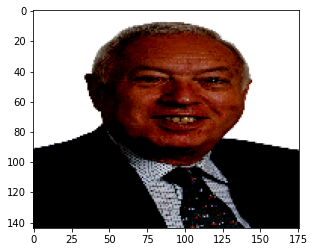

In [11]:
# Load, preprocess and print the test image
image_file = "mtcnn_esp32s3/representative_dataset/0089.jpg"
image_test = cv2.imread(image_file)
image_test = utils.preprocess_image(image_test, w, h, np.float32)
plt.imshow(image_test)

1/1 [==============================] - 0s 269ms/step
[array([[ 3.00000000e+01,  1.00000000e+01,  1.50000000e+02,
         1.30000000e+02,  9.31105733e-01,  1.68755457e-01,
         1.67170674e-01, -2.53027648e-01, -5.92354052e-02],
       [ 1.00000000e+01,  3.00000000e+01,  1.30000000e+02,
         1.50000000e+02,  7.66440749e-01,  3.40153903e-01,
         3.16687860e-02, -1.17971115e-02, -1.06624395e-01],
       [ 3.00000000e+01,  3.00000000e+01,  1.50000000e+02,
         1.50000000e+02,  9.14067209e-01,  1.62548050e-01,
         4.69510294e-02, -2.65067011e-01, -2.00463682e-01]])]
1/1 [==============================] - 0s 95ms/step
[array([[ 3.00000000e+01,  1.00000000e+01,  1.50000000e+02,
         1.30000000e+02,  9.31105733e-01,  1.68755457e-01,
         1.67170674e-01, -2.53027648e-01, -5.92354052e-02],
       [ 1.00000000e+01,  3.00000000e+01,  1.30000000e+02,
         1.50000000e+02,  7.66440749e-01,  3.40153903e-01,
         3.16687860e-02, -1.17971115e-02, -1.06624395e-01],
 

[array([[ 3.00000000e+01,  1.00000000e+01,  1.50000000e+02,
         1.30000000e+02,  9.31105852e-01,  1.68755427e-01,
         1.67170659e-01, -2.53027737e-01, -5.92353567e-02],
       [ 1.00000000e+01,  3.00000000e+01,  1.30000000e+02,
         1.50000000e+02,  7.66440928e-01,  3.40154052e-01,
         3.16687934e-02, -1.17969643e-02, -1.06624447e-01],
       [ 3.00000000e+01,  3.00000000e+01,  1.50000000e+02,
         1.50000000e+02,  9.14067328e-01,  1.62548095e-01,
         4.69510071e-02, -2.65067041e-01, -2.00463787e-01]])]
[array([[ 3.00000000e+01,  1.00000000e+01,  1.50000000e+02,
         1.30000000e+02,  9.31105852e-01,  1.68755427e-01,
         1.67170659e-01, -2.53027737e-01, -5.92353567e-02],
       [ 1.00000000e+01,  3.00000000e+01,  1.30000000e+02,
         1.50000000e+02,  7.66440928e-01,  3.40154052e-01,
         3.16687934e-02, -1.17969643e-02, -1.06624447e-01],
       [ 3.00000000e+01,  3.00000000e+01,  1.50000000e+02,
         1.50000000e+02,  9.14067328e-01,  1.62

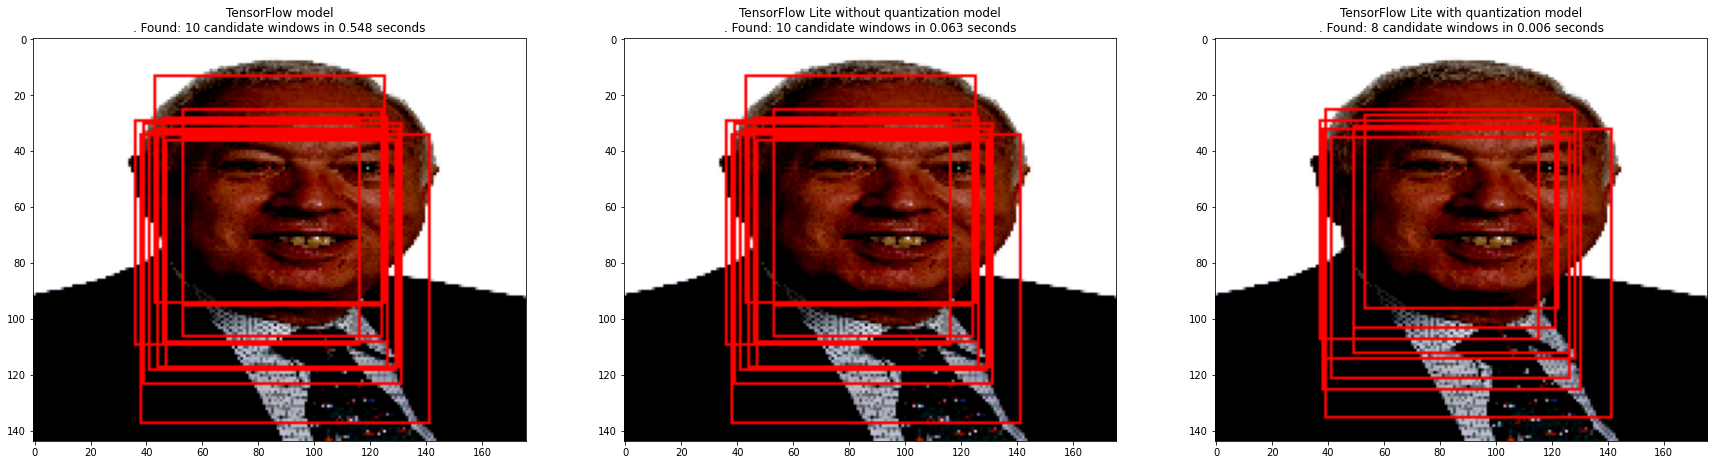

In [12]:
# P-Net

# TF
t0 = time.time() # Initial time to measure model time execution
candidate_windows = run_pnet(image_test, pnets)
pnet_time = time.time() - t0 # Model time execution
pnet_results = utils.draw_bboxes(image_test, candidate_windows) # Draw the bboxes in the image

# TF Lite no quantized
t0 = time.time() # Initial time to measure model time execution
candidate_windows_no_quant = run_pnet(image_test, pnets_no_quant, tflite=True)
pnet_no_quant_time = time.time() - t0 # Model time execution
pnet_no_quant_results = utils.draw_bboxes(image_test, candidate_windows_no_quant) # Draw the bboxes in the image

# TF Lite quantized
t0 = time.time() # Initial time to measure model time execution
candidate_windows_quant_int8 = run_pnet(image_test, pnets_quant_int8, tflite=True, quantized=True)
pnet_quant_int8_time = time.time() - t0 # Model time execution
pnet_quant_int8_results = utils.draw_bboxes(image_test, candidate_windows_quant_int8) # Draw the bboxes in the image

# Plot the results
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 22))
ax1.set_title("TensorFlow model\n. Found: " + str(candidate_windows.shape[0]) + " candidate windows" + " in " + str(np.round(pnet_time, 3)) + " seconds")
ax1.imshow(pnet_results) # TF
ax2.set_title("TensorFlow Lite without quantization model\n. Found: " + str(candidate_windows_no_quant.shape[0]) + " candidate windows" + " in " + str(np.round(pnet_no_quant_time, 3)) + " seconds")
ax2.imshow(pnet_no_quant_results) # TF no quantized
ax3.set_title("TensorFlow Lite with quantization model\n. Found: " + str(candidate_windows_quant_int8.shape[0]) + " candidate windows" + " in " + str(np.round(pnet_quant_int8_time, 3)) + " seconds")
ax3.imshow(pnet_quant_int8_results) # TF quantized

1/1 [==============================] - 0s 125ms/step


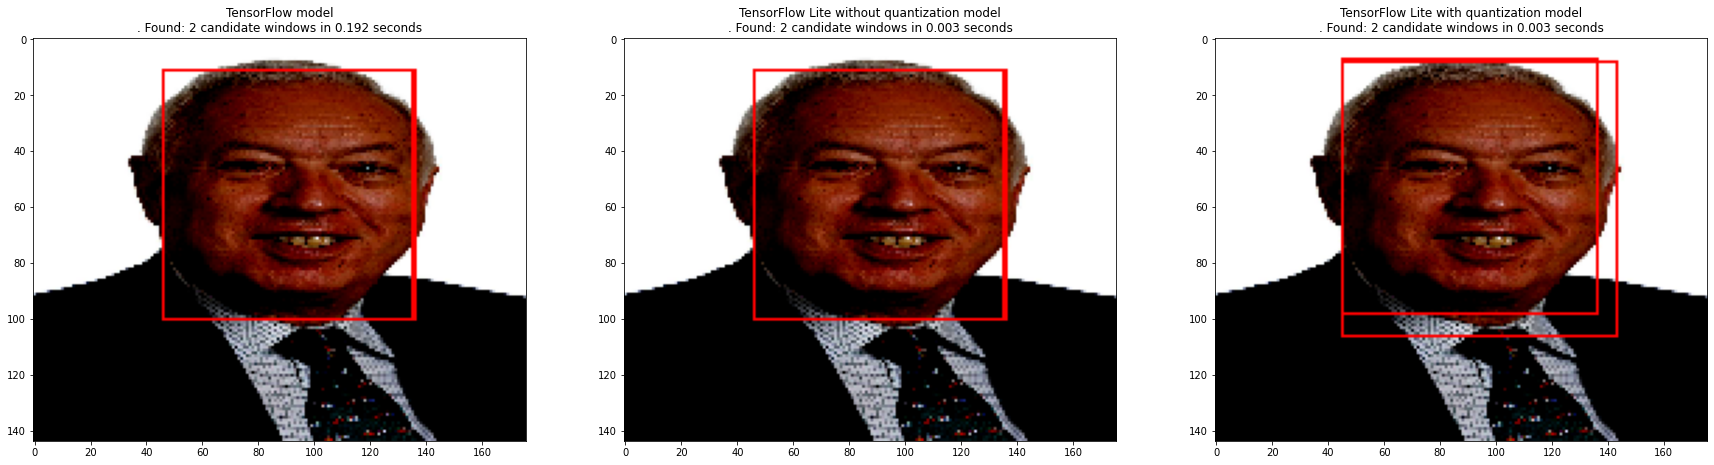

In [13]:
# R-Net

# TF
t0 = time.time() # Initial time to measure model time execution
candidate_windows = run_rnet(candidate_windows, rnet)
rnet_time = time.time() - t0 # Model time execution
rnet_results = utils.draw_bboxes(image_test, candidate_windows) # Draw the bboxes in the image

# TF no quantized
t0 = time.time() # Initial time to measure model time execution
candidate_windows_no_quant = run_rnet(candidate_windows_no_quant, rnet_no_quant, tflite=True)
rnet_no_quant_time = time.time() - t0 # Model time execution
rnet_no_quant_results = utils.draw_bboxes(image_test, candidate_windows_no_quant) # Draw the bboxes in the image

# TF quantized
t0 = time.time() # Initial time to measure model time execution
candidate_windows_quant_int8 = run_rnet(candidate_windows_quant_int8, rnet_quant_int8, tflite=True, quantized=True)
rnet_quant_int8_time = time.time() - t0 # Model time execution
rnet_quant_int8_results = utils.draw_bboxes(image_test, candidate_windows_quant_int8) # Draw the bboxes in the image

# Plot the results
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 22))
ax1.set_title("TensorFlow model\n. Found: " + str(candidate_windows.shape[0]) + " candidate windows" + " in " + str(np.round(rnet_time, 3)) + " seconds")
ax1.imshow(rnet_results) # TF
ax2.set_title("TensorFlow Lite without quantization model\n. Found: " + str(candidate_windows_no_quant.shape[0]) + " candidate windows" + " in " + str(np.round(rnet_no_quant_time, 3)) + " seconds")
ax2.imshow(rnet_no_quant_results) # TF no quantized
ax3.set_title("TensorFlow Lite with quantization model\n. Found: " + str(candidate_windows_quant_int8.shape[0]) + " candidate windows" + " in " + str(np.round(rnet_quant_int8_time, 3)) + " seconds")
ax3.imshow(rnet_quant_int8_results) # TF quantized

1/1 [==============================] - 0s 142ms/step


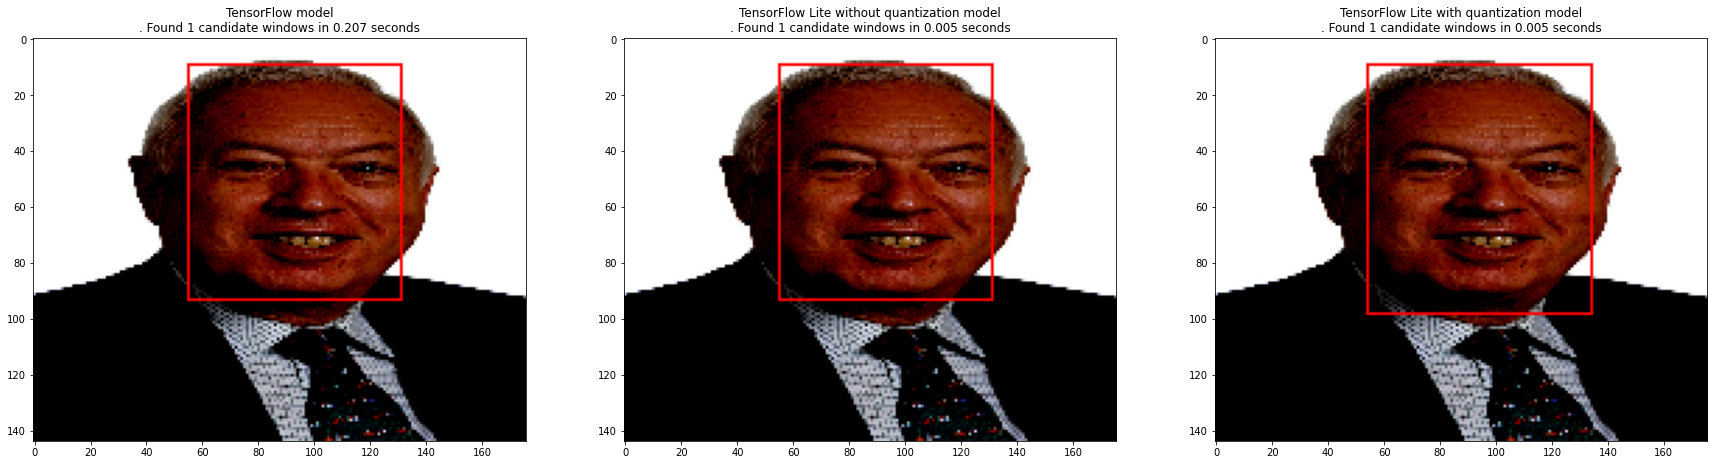

In [14]:
# O-Net

# TF
t0 = time.time() # Initial time to measure model time execution
candidate_windows = run_onet(candidate_windows, onet)
onet_time = time.time() - t0 # Model time execution
onet_results = utils.draw_bboxes(image_test, candidate_windows) # Draw the bboxes in the image

# TF no quantized
t0 = time.time() # Initial time to measure model time execution
candidate_windows_no_quant = run_onet(candidate_windows_no_quant, onet_no_quant, tflite=True)
onet_no_quant_time = time.time() - t0 # Model time execution
onet_no_quant_results = utils.draw_bboxes(image_test, candidate_windows_no_quant) # Draw the bboxes in the image

# TF quantized
t0 = time.time() # Initial time to measure model time execution
candidate_windows_quant_int8 = run_onet(candidate_windows_quant_int8, onet_quant_int8, tflite=True, quantized=True)
onet_quant_int8_time = time.time() - t0 # Model time execution
onet_quant_int8_results = utils.draw_bboxes(image_test, candidate_windows_quant_int8) # Draw the bboxes in the image

# Plot the results
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 22))
ax1.set_title("TensorFlow model\n. Found " + str(candidate_windows.shape[0]) + " candidate windows" + " in " + str(np.round(onet_time, 3)) + " seconds")
ax1.imshow(onet_results) # TF
ax2.set_title("TensorFlow Lite without quantization model\n. Found " + str(candidate_windows_no_quant.shape[0]) + " candidate windows" + " in " + str(np.round(onet_no_quant_time, 3)) + " seconds")
ax2.imshow(onet_no_quant_results) # TF no quantized
ax3.set_title("TensorFlow Lite with quantization model\n. Found " + str(candidate_windows_quant_int8.shape[0]) + " candidate windows" + " in " + str(np.round(onet_quant_int8_time, 3)) + " seconds")
ax3.imshow(onet_quant_int8_results) # TF quantized

# Models execution time comparison

In [15]:
# Compare P-Net models time
pd.DataFrame.from_records(
    [["P-Net TF", pnet_time],
     ["P-Net TF Lite no quantized", pnet_no_quant_time],
     ["P-Net TF Lite quantized", pnet_quant_int8_time]],
     columns = ["Model", "Time"], index="Model")

,Time
Model,
P-Net TF,0.547715
P-Net TF Lite no quantized,0.062894
P-Net TF Lite quantized,0.006174


In [16]:
# Compare R-Net models time
pd.DataFrame.from_records(
    [["R-Net TF", rnet_time],
     ["R-Net TF Lite no quantized", rnet_no_quant_time],
     ["R-Net TF Lite quantized", rnet_quant_int8_time]],
     columns = ["Model", "Time"], index="Model")

,Time
Model,
R-Net TF,0.191908
R-Net TF Lite no quantized,0.003195
R-Net TF Lite quantized,0.003309


In [17]:
# Compare O-Net models time
pd.DataFrame.from_records(
    [["O-Net TF", onet_time],
     ["O-Net TF Lite no quantized", onet_no_quant_time],
     ["O-Net TF Lite quantized", onet_quant_int8_time]],
     columns = ["Model", "Time"], index="Model")

,Time
Model,
O-Net TF,0.206886
O-Net TF Lite no quantized,0.004643
O-Net TF Lite quantized,0.004922


In [18]:
# Compare MTCNN models time
pd.DataFrame.from_records(
    [["MTCNN TF", pnet_time + rnet_time + onet_time],
     ["MTCNN TF Lite no quantized", pnet_no_quant_time + rnet_no_quant_time + onet_no_quant_time],
     ["MTCNN TF Lite quantized", pnet_quant_int8_time + rnet_quant_int8_time + onet_quant_int8_time]],
     columns = ["Model", "Time"], index="Model")

,Time
Model,
MTCNN TF,0.946509
MTCNN TF Lite no quantized,0.070732
MTCNN TF Lite quantized,0.014405


# Models size comparison

In [19]:
# Calculate size for P-Net models
pnet_scale_1_size = os.path.getsize(PNET_SCALE_1_TF)
pnet_scale_2_size = os.path.getsize(PNET_SCALE_2_TF)
pnet_scale_1_no_quant_size = os.path.getsize(PNET_SCALE_1_NO_QUANT_TFLITE)
pnet_scale_2_no_quant_size = os.path.getsize(PNET_SCALE_2_NO_QUANT_TFLITE)
pnet_scale_1_quant_int8_size = os.path.getsize(PNET_SCALE_1_QUANT_INT8_TFLITE)
pnet_scale_2_quant_int8_size = os.path.getsize(PNET_SCALE_2_QUANT_INT8_TFLITE)

In [20]:
# Compare size
pd.DataFrame.from_records(
    [["P-Net scale 1 TF", f"{pnet_scale_1_size} bytes", ""],
     ["P-Net scale 1 TF Lite no quantized", f"{pnet_scale_1_no_quant_size} bytes ", f"(reduced by {pnet_scale_1_size - pnet_scale_1_no_quant_size} bytes)"],
     ["P-Net scale 1 TF Lite quantized", f"{pnet_scale_1_quant_int8_size} bytes", f"(reduced by {pnet_scale_1_no_quant_size - pnet_scale_1_quant_int8_size} bytes)"],
     ["P-Net scale 2 TF", f"{pnet_scale_2_size} bytes", ""],
     ["P-Net scale 2 TF Lite no quantized", f"{pnet_scale_2_no_quant_size} bytes ", f"(reduced by {pnet_scale_2_size - pnet_scale_2_no_quant_size} bytes)"],
     ["P-Net scale 2 TF Lite quantized", f"{pnet_scale_2_quant_int8_size} bytes", f"(reduced by {pnet_scale_2_no_quant_size - pnet_scale_2_quant_int8_size} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
P-Net scale 1 TF,4096 bytes,
P-Net scale 1 TF Lite no quantized,30936 bytes,(reduced by -26840 bytes)
P-Net scale 1 TF Lite quantized,13848 bytes,(reduced by 17088 bytes)
P-Net scale 2 TF,4096 bytes,
P-Net scale 2 TF Lite no quantized,31056 bytes,(reduced by -26960 bytes)
P-Net scale 2 TF Lite quantized,13984 bytes,(reduced by 17072 bytes)


In [21]:
# Calculate size for R-Net models
rnet_size = os.path.getsize(RNET_TF)
rnet_no_quant_size = os.path.getsize(RNET_NO_QUANT_TFLITE)
rnet_quant_int8_size = os.path.getsize(RNET_QUANT_INT8_TFLITE)

In [22]:
# Compare size
pd.DataFrame.from_records(
    [["R-Net TF", f"{rnet_size} bytes", ""],
     ["R-Net TF Lite no quantized", f"{rnet_no_quant_size} bytes ", f"(reduced by {rnet_size - rnet_no_quant_size} bytes)"],
     ["R-Net TF Lite quantized", f"{rnet_quant_int8_size} bytes", f"(reduced by {rnet_no_quant_size - rnet_quant_int8_size} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
R-Net TF,4096 bytes,
R-Net TF Lite no quantized,406624 bytes,(reduced by -402528 bytes)
R-Net TF Lite quantized,111632 bytes,(reduced by 294992 bytes)


In [23]:
# Calculate size for O-Net models
onet_size = os.path.getsize(ONET_TF)
onet_no_quant_size = os.path.getsize(ONET_NO_QUANT_TFLITE)
onet_quant_int8_size = os.path.getsize(ONET_QUANT_INT8_TFLITE)

In [24]:
# Compare sizes
pd.DataFrame.from_records(
    [["O-Net TF", f"{onet_size} bytes", ""],
     ["O-Net TF Lite no quantized", f"{onet_no_quant_size} bytes ", f"(reduced by {onet_size - onet_no_quant_size} bytes)"],
     ["O-Net TF Lite quantized", f"{onet_quant_int8_size} bytes", f"(reduced by {onet_no_quant_size - onet_quant_int8_size} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
O-Net TF,4096 bytes,
O-Net TF Lite no quantized,1552844 bytes,(reduced by -1548748 bytes)
O-Net TF Lite quantized,403544 bytes,(reduced by 1149300 bytes)


# Generate TF Lite for Microcontrollers models

In [25]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {PNET_SCALE_1_QUANT_INT8_TFLITE} > {PNET_SCALE_1_TFLITE_MICRO}
!xxd -i {PNET_SCALE_2_QUANT_INT8_TFLITE} > {PNET_SCALE_2_TFLITE_MICRO}
!xxd -i {RNET_QUANT_INT8_TFLITE} > {RNET_TFLITE_MICRO}
!xxd -i {ONET_QUANT_INT8_TFLITE} > {ONET_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = PNET_SCALE_1_QUANT_INT8_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/pnet_scale_1_model/g' {PNET_SCALE_1_TFLITE_MICRO}
REPLACE_TEXT = PNET_SCALE_2_QUANT_INT8_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/pnet_scale_2_model/g' {PNET_SCALE_2_TFLITE_MICRO}
REPLACE_TEXT = RNET_QUANT_INT8_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/rnet_model/g' {RNET_TFLITE_MICRO}
REPLACE_TEXT = ONET_QUANT_INT8_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/onet_model/g' {ONET_TFLITE_MICRO}

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:7 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal/main Sources [2,404 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal/main amd64 Packages [1,139 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/multiverse amd